In [132]:
# %%capture
# %load_ext autoreload
# %autoreload 2
#Basic Imports
import os,sys
os.chdir('/home/asebaq/MSMatch')

from tqdm import tqdm,trange
import numpy as np
from sklearn.metrics import classification_report
import torch

from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
from utils import get_model_checkpoints
from utils import net_builder
from utils import plot_examples, plot_cmatrix

import pandas as pd
from termcolor import colored
from copy import deepcopy

In [133]:
! pip install termcolor

## Initialize parameters

In [134]:
eurosat_MS_path="/home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD"

#ucm_path = "/scratch/fixmatch_results/runs_new_paper_version/nr_of_labels/ucm/FixMatch_archefficientnet-b2_batch16_confidence0.95_lr0.03_uratio4_wd0.00075_wu1.0_seed0_numlabels105_optSGD"

In [135]:
#eurosat_rgb_path="/home/asebaq/MSMatch/saved_models/fixmatch/eurosat_rgb/FixMatch_archefficientnet-b0_batch16_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels4000_optSGD"


In [136]:
use_all_seeds=True
path = eurosat_MS_path

In [137]:
checkpoints, args = get_model_checkpoints(path)
args = args[0]

In [138]:
args

{'dataset': 'eurosat_ms',
 'net': 'efficientnet-b0',
 'batch': 64,
 'confidence': 0.95,
 'lr': 0.03,
 'uratio': 7,
 'wd': 0.0005,
 'wu': 1.0,
 'seed': 0,
 'numlabels': 50,
 'opt': 'SGD',
 'iterations': 567000}

In [139]:
args["batch_size"] = 256
args["data_dir"] = "./MSMatch/data/"
args["use_train_model"] = False
args["load_path"] = checkpoints[0]

## Eval

In [140]:
checkpoint["train_model"]

OrderedDict([('_conv_stem.weight',
              tensor([[[[-3.0334e-02, -2.8599e-02, -2.9004e-02],
                        [-3.4094e-02, -3.3307e-02, -3.1509e-02],
                        [-3.4242e-02, -3.4661e-02, -3.3477e-02]],
              
                       [[-9.5263e-03, -4.1525e-03, -2.8593e-03],
                        [-1.1926e-02, -9.0488e-03, -1.1059e-02],
                        [-1.6092e-02, -1.0411e-02, -1.1799e-02]],
              
                       [[ 3.8219e-04,  5.2058e-03,  8.1377e-03],
                        [ 1.9749e-04,  3.7322e-03,  2.1290e-03],
                        [-3.7665e-03,  2.5826e-03, -1.3209e-03]],
              
                       ...,
              
                       [[-1.0598e-03, -7.2380e-03, -7.6458e-04],
                        [ 2.2713e-04,  6.4586e-04, -1.3321e-04],
                        [-2.3708e-03, -3.6121e-03,  3.8226e-04]],
              
                       [[ 4.3969e-03, -1.0728e-03, -1.0336e-04],
             

In [142]:
checkpoint_path = os.path.join(args["load_path"])
checkpoint = torch.load(checkpoint_path)
load_model = (checkpoint["train_model"] if args["use_train_model"] else checkpoint["eval_model"])

_eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=args["seed"])
eval_dset = _eval_dset.get_dset()

_net_builder = net_builder(args["net"],None,{})

net = _net_builder(num_classes=_eval_dset.num_classes, in_channels=_eval_dset.num_channels)
net.load_state_dict(load_model)
if torch.cuda.is_available():
    net.cuda()
net.eval()



eval_loader = get_data_loader(eval_dset, args["batch"], num_workers=1)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.50s/it]


Using not pretrained model efficientnet-b0 ...


## Evaluate

In [145]:
label_encoding = _eval_dset.label_encoding
inv_transf = _eval_dset.inv_transform

Number of different classes found: 10


TypeError: Invalid shape (64, 64, 13) for image data

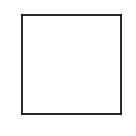

In [146]:


plot_examples(eval_dset.data,eval_dset.targets,label_encoding)

In [147]:
#Assemble a batch
images, labels, preds = [],[],[]
with torch.no_grad():
    for image, target in tqdm(eval_loader):
        if image.shape[2] == 1:
            image = image[:, :, 0]
    
        image = image.type(torch.FloatTensor).cuda()
        logit = net(image)
        for idx,img in enumerate(image):
            images.append(inv_transf(img.transpose(0,2).cpu().numpy()).transpose(0,2).numpy())
        preds.append(logit.cpu().max(1)[1])
        labels.append(target)
labels = torch.cat(labels).numpy()
preds = torch.cat(preds).numpy()

100%|███████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 26.22it/s]


Number of different classes found: 10


TypeError: Invalid shape (64, 64, 13) for image data

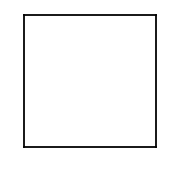

In [148]:

plot_examples(images,labels,label_encoding, (10,6), 160, 6,preds, args["dataset"]+".png")

## Evaluate all test data

In [149]:
if use_all_seeds:
    labels, preds = [],[]
    
    for seed in [0,1,2]:
        
        print("Processing seed:", colored(seed,"red"))
        checkpoint_path=checkpoints[0].replace("seed"+str(checkpoints[0][checkpoints[0].find("seed")+4]), "seed"+str(seed))
        print(checkpoint_path)
        
        checkpoint = torch.load(checkpoint_path,map_location='cuda:0')
        load_model = (checkpoint["train_model"] if args["use_train_model"] else checkpoint["eval_model"])
        _net_builder = net_builder(args["net"],False,{})
        _eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=seed)
        eval_dset = _eval_dset.get_dset()
        net = _net_builder(num_classes=_eval_dset.num_classes, in_channels=_eval_dset.num_channels)
        net.load_state_dict(load_model)
        if torch.cuda.is_available():
            net.cuda()
        net.eval()
        eval_loader = get_data_loader(eval_dset, args["batch"], num_workers=1)
        
        #Assemble a batch
        labels_seed, preds_seed = [],[]
        with torch.no_grad():
            for image, target in tqdm(eval_loader):
                image = image.type(torch.FloatTensor).cuda()
                logit = net(image)
                
                preds_seed.append(logit.cpu().max(1)[1])
                labels_seed.append(target)
                
        preds.append(torch.cat(preds_seed).numpy())
        labels.append(torch.cat(labels_seed).numpy())
    
    

Processing seed: 0
/home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD/model_best.pth
Using not pretrained model efficientnet-b0 ...


100%|███████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 52.27it/s]

Processing seed: 1
/home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed1_numlabels50_optSGD/model_best.pth


FileNotFoundError: [Errno 2] No such file or directory: '/home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed1_numlabels50_optSGD/model_best.pth'

In [ ]:
if use_all_seeds:
    test_report_list=[]
    for labels_seed, preds_seed in zip(labels, preds):
        test_seed=classification_report(labels_seed, preds_seed, target_names=label_encoding, output_dict=True)
        test_seed_keys=list(test_seed.keys())[:-3]
        test_seed_values=list(test_seed.values())[:-3]
        test_report_list.append(dict(zip(test_seed_keys, test_seed_values)))
        test_report_keys=list(test_report_list[0].keys())
    test_report=deepcopy(test_report_list[0])
    
    for key in list(test_report_keys):
        test_report[key]['precision']=0.0
        test_report[key]['recall']=0.0
        test_report[key]['f1-score']=0.0
        test_report[key]['support']=0.0
    
    for key in list(test_report_keys):
        for n in range(len(test_report_list)):
            test_report[key]['precision']+=test_report_list[n][key]['precision']/len(test_report_list)
            test_report[key]['recall']+=test_report_list[n][key]['recall']/len(test_report_list)
            test_report[key]['f1-score']+=test_report_list[n][key]['f1-score']/len(test_report_list)
            test_report[key]['support']+=test_report_list[n][key]['support']/len(test_report_list)

        
else:
    test_report = classification_report(labels, preds, target_names=label_encoding, output_dict=True)[:-3]
    

df = pd.DataFrame(test_report)
print(df)
df.to_csv("./"+str(args["dataset"])+"_"+str(args["numlabels"]) + "_test_results.csv")


In [ ]:

plot_cmatrix(preds,labels,label_encoding, figsize=(10, 8),dpi=150, class_names_font_scale=1.6, matrix_font_size=12, save_fig_name=str(args["dataset"])+"_"+str(args["numlabels"])+"_cm.png")